Author: **Stefano Petrocchi**


## Dependencies and Variables:

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import datetime
import os
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from keras.layers.merge import concatenate
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.python.util import deprecation
import pickle


deprecation._PRINT_DEPRECATION_WARNINGS = False

disable_eager_execution() #To execute the gradient

BASE_PATH = "drive/MyDrive/Petrocchi"
MODELS_PATH = BASE_PATH + "/models"
DATA_PATH = BASE_PATH + "/data/"
CHECKPOINT_PATH = BASE_PATH + "/checkpoints"
HISTORY_PATH = BASE_PATH + "/history"

labels_dict = {
  "0": "BASELINE",
  "1": "MASS BENIGN",
  "2": "MASS MALIGNANT",
  "3": "CALCIFICATION BENIGN",
  "4": "CALCIFICATION MALIGNANT"
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q pyyaml h5py

In [4]:
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=c6501fb3c034820c98d106637423712192e826db4dee48053db490d96f13b95d
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [5]:
# Get util functions
import import_ipynb
import drive.MyDrive.Petrocchi.util.preprocessing as preprocessing
import drive.MyDrive.Petrocchi.util.models as my_models
import drive.MyDrive.Petrocchi.util.visualization as visual
import drive.MyDrive.Petrocchi.util.SVM as svm

importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/preprocessing.ipynb
"load_images_and_lables" function loaded
"preprocess_normalize_images" function loaded
"deprocess_image_to_RGB" function loaded
"deprocess_image" function loaded
"datagen" class loaded
"binary_subdivision" function loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/models.ipynb
"tiny_net" CNN loaded
"mammo_net" CNN loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/visualization.ipynb
"plot_history" function loaded
"plot_roc_curve" function loaded
"plot_confusion_matrix" function loaded
"generate_pattern" function loaded
"display_filters_patterns" function loaded
"display_features_maps" function loaded
"generate_pattern_RGB" function loaded
"display_filters_patterns" function loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/SVM.ipynb
"create_feature_extractor" function loaded
"extract_features" function loaded
"train_s

## Data Loading:

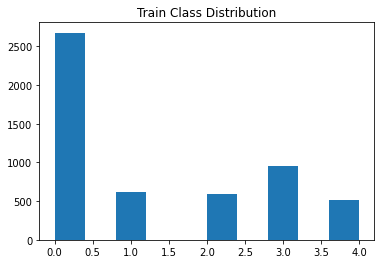

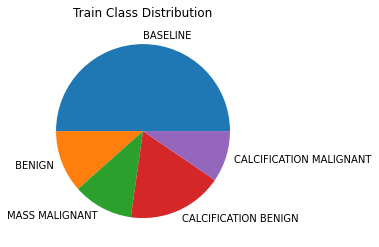

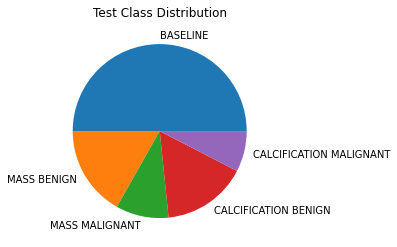

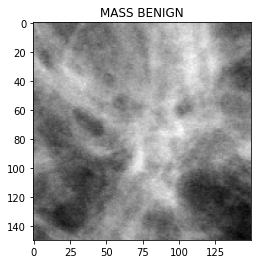

In [6]:
train_images, train_labels= preprocessing.load_images_and_lables(DATA_PATH + 'train_tensor.npy', DATA_PATH + 'train_labels.npy')
test_images, test_labels= preprocessing.load_images_and_lables(DATA_PATH + 'public_test_tensor.npy', DATA_PATH + 'public_test_labels.npy')

# Class Distribution
plt.hist(train_labels)
plt.title("Train Class Distribution")
plt.show()

unique, counts = np.unique(train_labels, return_counts=True)
plt.pie(counts, labels = ["BASELINE"," BENIGN","MASS MALIGNANT","CALCIFICATION BENIGN","CALCIFICATION MALIGNANT"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(test_labels, return_counts=True)
plt.pie(counts, labels = ["BASELINE","MASS BENIGN","MASS MALIGNANT","CALCIFICATION BENIGN","CALCIFICATION MALIGNANT"])
plt.title('Test Class Distribution')
plt.show()

# Plot an example
img_index = 5
plt.imshow(train_images[img_index,:,:],cmap = 'gray')
plt.title(labels_dict[str(train_labels[img_index])])
plt.show()

## General Data Preprocessing:

Normalize and convert to RGB:

In [7]:
# I also need to convert back to numpy array using eval()
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
with sess.as_default():
  print(train_images.shape)
  pp_train_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(preprocessing.preprocess_normalize_images(train_images, train_images.mean(), train_images.std()))).eval()
  print(pp_train_images.shape)

  print(test_images.shape)
  pp_test_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(preprocessing.preprocess_normalize_images(test_images, train_images.mean(), train_images.std()))).eval()
  print(pp_test_images.shape)

(5352, 150, 150)
(5352, 150, 150, 3)
(672, 150, 150)
(672, 150, 150, 3)


Abnormalities-Baselines subdivision

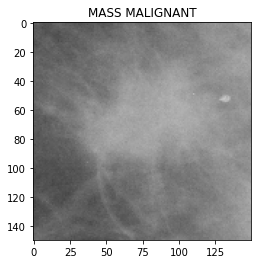

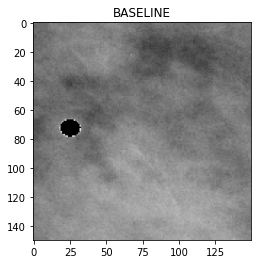

In [8]:
# For reference
idx = 1
plt.imshow(preprocessing.deprocess_image_to_RGB(pp_train_images[idx]))
plt.title(labels_dict[str(train_labels[idx])])
plt.show()
plt.imshow(preprocessing.deprocess_image_to_RGB(pp_train_images[idx-1]))
plt.title(labels_dict[str(train_labels[idx-1])])
plt.show()

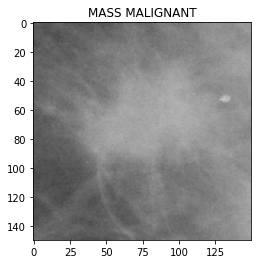

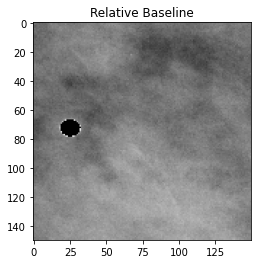

In [9]:
#Train
train_abnormalities = pp_train_images[1::2]
train_abnormalities_labels = train_labels[1::2]
train_baselines = pp_train_images[::2]

#Test
test_abnormalities = pp_test_images[1::2]
test_abnormalities_labels = test_labels[1::2]
test_baselines = pp_test_images[::2]

# Confirms that subdivision is good
idx = 0
plt.imshow(preprocessing.deprocess_image_to_RGB(train_abnormalities[idx]))
plt.title(labels_dict[str(train_abnormalities_labels[idx])])
plt.show()
plt.imshow(preprocessing.deprocess_image_to_RGB(train_baselines[idx]))
plt.title("Relative Baseline")
plt.show()

Test Augmentation:

(1, 150, 150, 3)


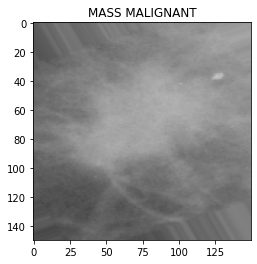

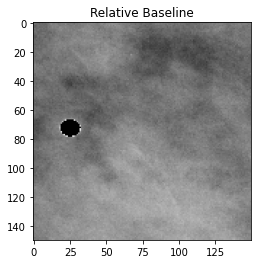

In [10]:
# Test: show random augmented image
for batch in preprocessing.datagen.flow([train_abnormalities[0:1],train_baselines[0:1]], train_abnormalities_labels[0:1], batch_size=1):
    plt.title(labels_dict[str(batch[1][0])])
    print(batch[0][0].shape)
    plt.imshow(preprocessing.deprocess_image_to_RGB(batch[0][0][0][:,:,:]))
    plt.show()
    plt.imshow(preprocessing.deprocess_image_to_RGB(batch[0][1][0][:,:,:]))
    plt.title("Relative Baseline")
    plt.show()
    break

Binary subdivision:

Masses and Calcifications
(2676, 150, 150, 3)
(2676,)
(336, 150, 150, 3)
(336,)


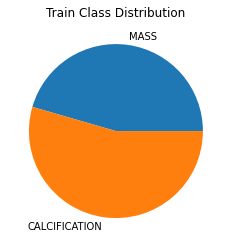

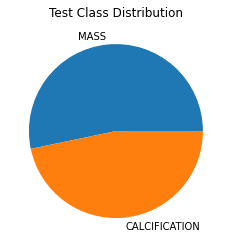

In [11]:
# 0: MASS, 1: CALCIFICATION
mc_train_images, mc_train_labels, mc_test_images, mc_test_labels = preprocessing.binary_subdivision( 
    [1,2], [3,4], train_abnormalities, train_abnormalities_labels, test_abnormalities, test_abnormalities_labels)  

print("Masses and Calcifications")
print(mc_train_images.shape)
print(mc_train_labels.shape)
print(mc_test_images.shape)
print(mc_test_labels.shape)

# Class Distribution
unique, counts = np.unique(mc_train_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(mc_test_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Test Class Distribution')
plt.show()


# Ensemble Mass VS Calcification Classifiers

### Split:

(2140, 150, 150, 3)
(2140,)
(536, 150, 150, 3)
(536,)
(2140, 150, 150, 3)
(536, 150, 150, 3)


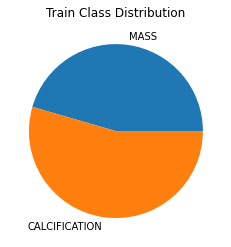

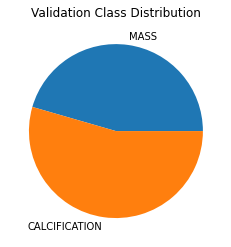

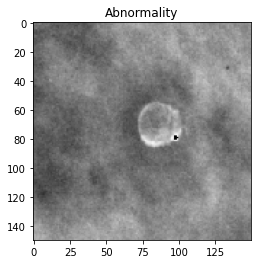

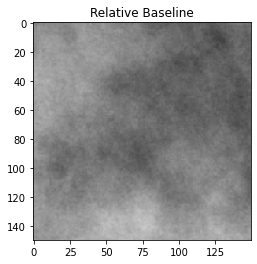

In [12]:
mc_train_images, mc_train_labels, mc_val_images, mc_val_labels, mc_val_baselines, mc_train_baselines = preprocessing.split_train_validation_baseline(mc_train_images, mc_train_labels, 0.2, train_baselines)

print(mc_train_images.shape)
print(mc_train_labels.shape)
print(mc_val_images.shape)
print(mc_val_labels.shape)
print(mc_train_baselines.shape)
print(mc_val_baselines.shape)

# Class Distribution
unique, counts = np.unique(mc_train_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(mc_val_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Validation Class Distribution')
plt.show()

idx = 22
plt.imshow(preprocessing.deprocess_image_to_RGB(mc_val_images[idx]))
plt.title("Abnormality")
plt.show()
plt.imshow(preprocessing.deprocess_image_to_RGB(mc_val_baselines[idx]))
plt.title("Relative Baseline")
plt.show()

###General Parameters for training:

In [13]:
# Training parameters that are good for all models

# From ISMMS paper 32
# From Girona & Manchester paper 128
BATCH_SIZE = 107 # to have even batches 
STEPS_PER_EPOCH = len(mc_train_images) // BATCH_SIZE # 20
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001) 
LOSS = 'binary_crossentropy'

# Large values ensures to not lose better weights 
MAX_EPOCHS = 1000 
PATIENCE = 50 

# Automatically restore best weights after early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)

### Load Previous Models

In [14]:
# !!!!To avoid graph errors!!!!
tf.compat.v1.reset_default_graph()
models_acc = np.asarray([])
train_input = []
validate_input = []
test_input = []
test_input_for_weghted = []

In [17]:
ResNet50_TL_mc = keras.models.load_model(os.path.join(MODELS_PATH,'ResNet50_TL_mc.h5'))
val_loss, val_acc = ResNet50_TL_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
models_acc = np.append(models_acc, val_acc)
train_input.append(mc_train_images)
validate_input.append(mc_val_images)
test_input.append(mc_test_images)
test_input_for_weghted.append(mc_test_images)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on validation set: 86.57% 
Loss on validation set: 0.338


In [18]:
VGG16_FT_mc = keras.models.load_model(os.path.join(MODELS_PATH,'VGG16_FT_mc.h5'))
val_loss, val_acc = VGG16_FT_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
models_acc = np.append(models_acc, val_acc)
train_input.append(mc_train_images)
validate_input.append(mc_val_images)
test_input.append(mc_test_images)
test_input_for_weghted.append(mc_test_images)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on validation set: 94.03% 
Loss on validation set: 0.205


In [19]:
InceptionV3_FT_mc = keras.models.load_model(os.path.join(MODELS_PATH,'InceptionV3_FT_mc.h5'))
val_loss, val_acc = InceptionV3_FT_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
models_acc = np.append(models_acc, val_acc)
train_input.append(mc_train_images)
validate_input.append(mc_val_images)
test_input.append(mc_test_images)
test_input_for_weghted.append(mc_test_images)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on validation set: 88.81% 
Loss on validation set: 0.3347


In [20]:
siamese_mc_difference = keras.models.load_model(os.path.join(MODELS_PATH,'siamese_mc_difference.h5'))
val_loss, val_acc = siamese_mc_difference.evaluate([mc_val_images, mc_val_baselines], mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
models_acc = np.append(models_acc, val_acc)
train_input.append(mc_train_images)
train_input.append(mc_train_baselines)
validate_input.append(mc_val_images)
validate_input.append(mc_val_baselines)
test_input.append(mc_test_images)
test_input.append(test_baselines)
test_input_for_weghted.append([mc_test_images,test_baselines])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on validation set: 84.51% 
Loss on validation set: 0.3712


In [21]:
siamese_mc_concat = keras.models.load_model(os.path.join(MODELS_PATH,'siamese_mc_concat.h5'))
val_loss, val_acc = siamese_mc_concat.evaluate([mc_val_images, mc_val_baselines], mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
models_acc = np.append(models_acc, val_acc)
train_input.append(mc_train_images)
train_input.append(mc_train_baselines)
validate_input.append(mc_val_images)
validate_input.append(mc_val_baselines)
test_input.append(mc_test_images)
test_input.append(test_baselines)
test_input_for_weghted.append([mc_test_images,test_baselines])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on validation set: 86.57% 
Loss on validation set: 0.2918


In [22]:
members = np.asarray([ResNet50_TL_mc, VGG16_FT_mc, InceptionV3_FT_mc, siamese_mc_difference, siamese_mc_concat])

##Weighted Ensemble

In [23]:
def ensemble_weighted_prediction(models, models_acc, inputs):
  '''
  Predict inputs class as weighted sum of models predictions by their total accuracy
  '''
  softmax_array = np.exp(models_acc)/sum(np.exp(models_acc))
  ensemble_prediction = 0
  for model, weight, input in zip(models, softmax_array,inputs):
    ensemble_prediction += model.predict(input)*weight
  return ensemble_prediction

In [24]:
# To try different combinations
idx = [0,1,2,3,4]

In [25]:
test_acc = accuracy_score(mc_test_labels, ensemble_weighted_prediction(members[idx], models_acc[idx],test_input_for_weghted).round())
print(f"Accuracy on test set: {round(test_acc*100, 2)}%")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on test set: 90.77%


##Stacking Ensemble

In [ ]:
# update all layers in all models to not be trainable
for i in range(len(members)):
	model = members[i]
	for layer in model.layers:
		# make not trainable
		layer.trainable = False
		# rename to avoid 'unique layer name' issue
		layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
resnet50_input (InputLayer)     [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
vgg16_input (InputLayer)        [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3_input (InputLayer) [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
ensemble_4_left_input (InputLay [(None, 150, 150, 3) 0                                            
______________________________________________________________________________________________

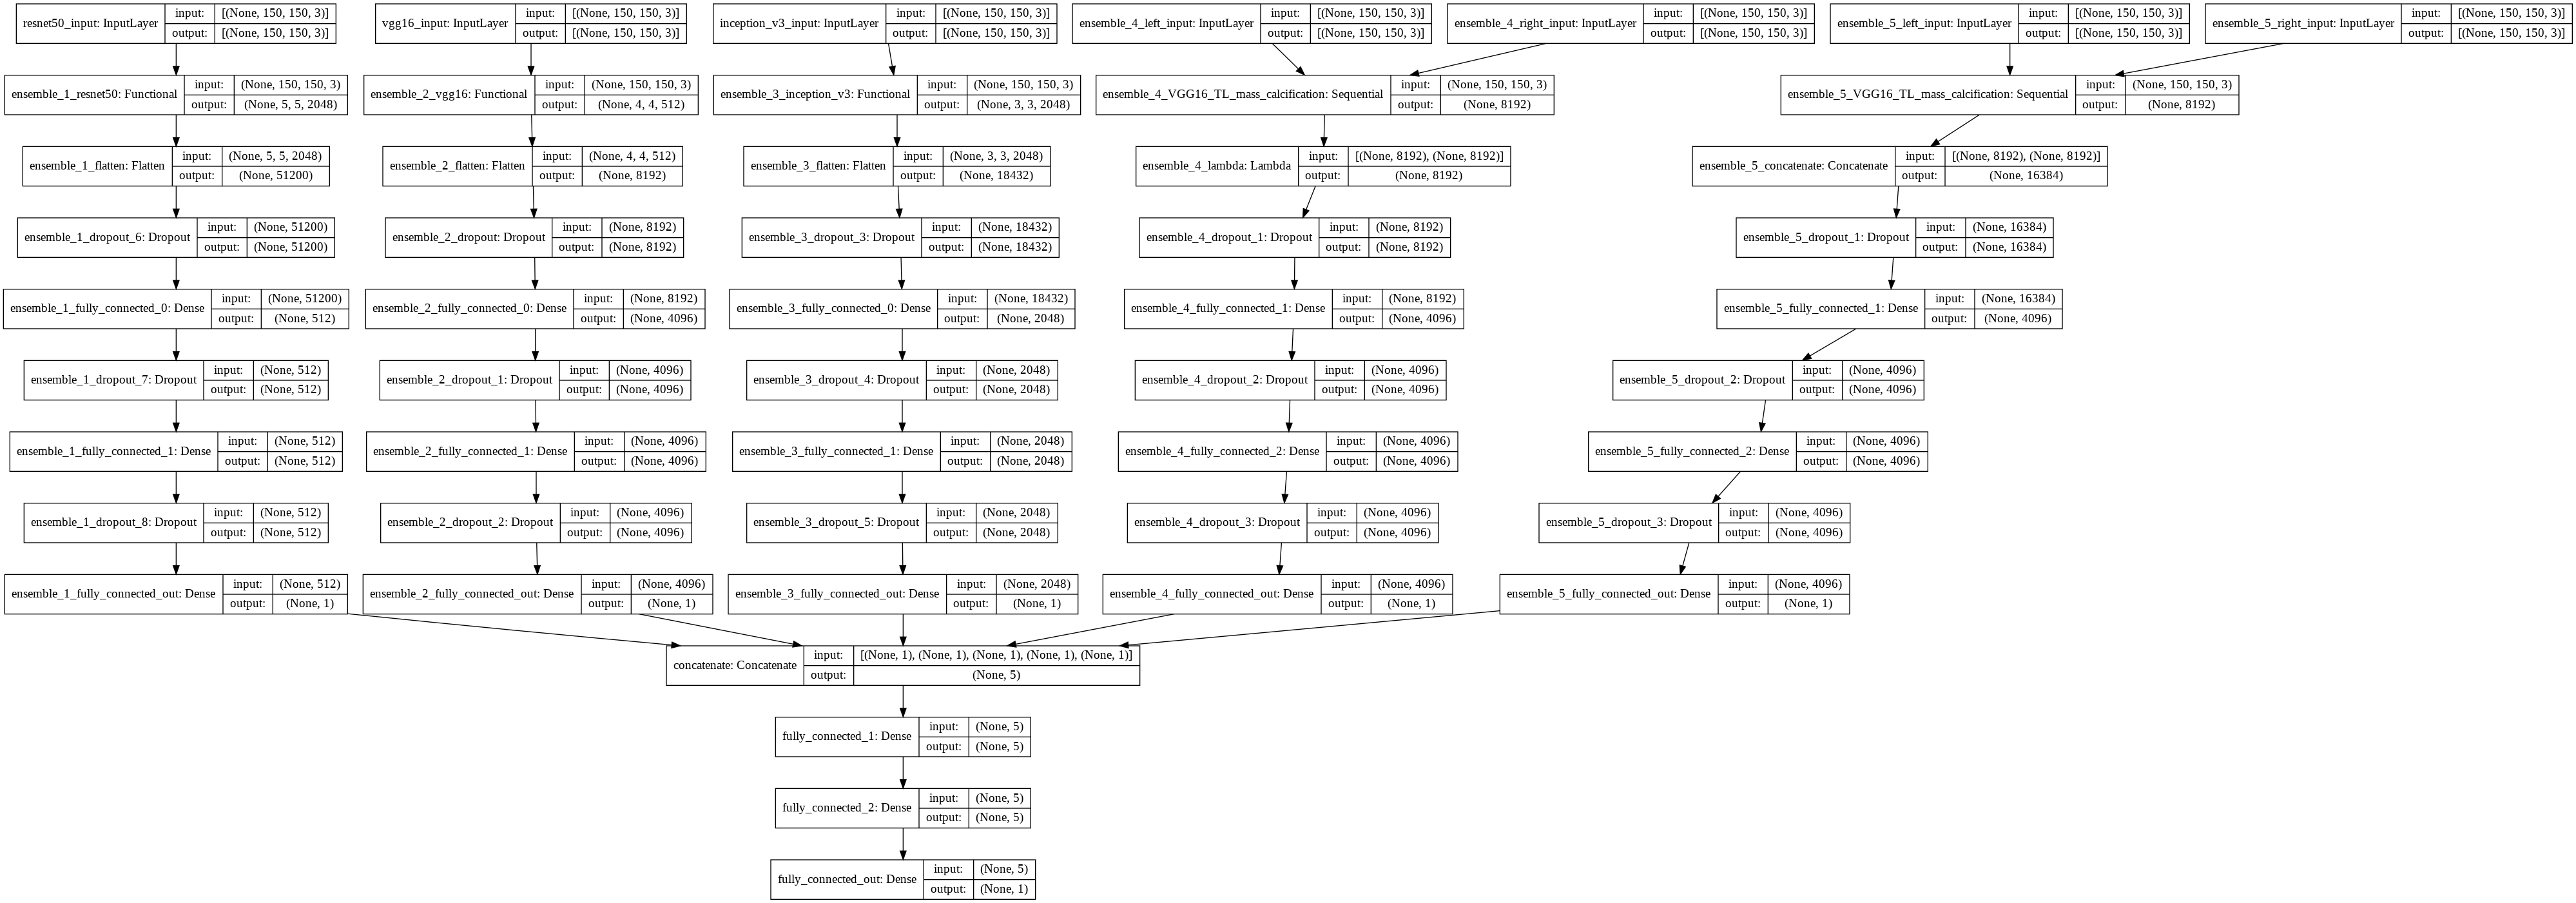

In [ ]:
# define multi-headed input
ensemble_visible = [model.input for model in members]
# concatenate merge output from each model
ensemble_outputs = [model.output for model in members]
merge = concatenate(ensemble_outputs)
fc1 = layers.Dense(5, activation='relu', name = "fully_connected_1")(merge)
fc2 = layers.Dense(5, activation='relu', name = "fully_connected_2")(fc1)
output = layers.Dense(1, activation='sigmoid', name = "fully_connected_out")(fc2)
ensemle_mc = Model(inputs=ensemble_visible, outputs=output)

ensemle_mc.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/ensemle_mc/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

# plot graph of ensemble
ensemle_mc.summary()
plot_model(ensemle_mc, show_shapes=True)

Training:

In [ ]:
ensemle_mc_history = ensemle_mc.fit(train_input, mc_train_labels, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, validation_data = (validate_input, mc_val_labels), callbacks=[es_callback])

Train on 2140 samples, validate on 536 samples
Epoch 1/1000
2140/2140 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.7846

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2140/2140 [==============================] - 46s 22ms/sample - loss: 0.6743 - accuracy: 0.7846 - val_loss: 0.6698 - val_accuracy: 0.8396
Epoch 2/1000
2140/2140 [==============================] - 39s 18ms/sample - loss: 0.6620 - accuracy: 0.8336 - val_loss: 0.6583 - val_accuracy: 0.8619
Epoch 3/1000
2140/2140 [==============================] - 38s 18ms/sample - loss: 0.6467 - accuracy: 0.8692 - val_loss: 0.6424 - val_accuracy: 0.8713
Epoch 4/1000
2140/2140 [==============================] - 38s 18ms/sample - loss: 0.6254 - accuracy: 0.9107 - val_loss: 0.6218 - val_accuracy: 0.8787
Epoch 5/1000
2140/2140 [==============================] - 38s 18ms/sample - loss: 0.5988 - accuracy: 0.9388 - val_loss: 0.5949 - val_accuracy: 0.8899
Epoch 6/1000
2140/2140 [==============================] - 38s 18ms/sample - loss: 0.5665 - accuracy: 0.9425 - val_loss: 0.5629 - val_accuracy: 0.8955
Epoch 7/1000
2140/2140 [==============================] - 38s 18ms/sample - loss: 0.5266 - accuracy: 0.9537 - val

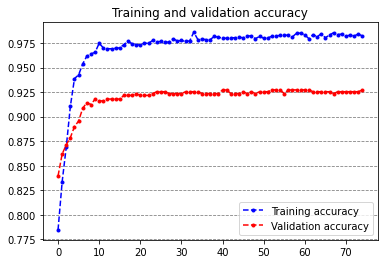

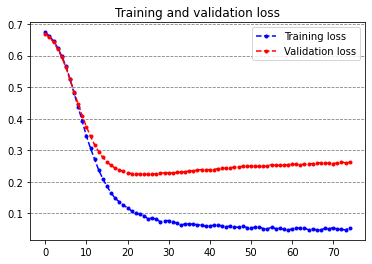

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/ensemle_mc_history', 'wb') as file_pi:
        pickle.dump(ensemle_mc_history.history, file_pi)

ensemle_mc_history = pickle.load(open(HISTORY_PATH + '/ensemle_mc_history', "rb"))

visual.plot_history(ensemle_mc_history)

In [ ]:
train_loss, train_acc = ensemle_mc.evaluate(train_input, mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = ensemle_mc.evaluate(validate_input, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = ensemle_mc.evaluate(test_input, mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 97.06% 
Loss on train set: 0.096
Accuracy on validation set: 92.54% 
Loss on validation set: 0.2234
Accuracy on test set: 91.67% 
Loss on test set: 0.2408


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/ensemle_mc/")
#ensemle_mc.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
ensemle_mc.save(os.path.join(MODELS_PATH,'ensemle_mc.h5'))

# Compare Results

##Scoring:

Accuracy on test set: 90.77%


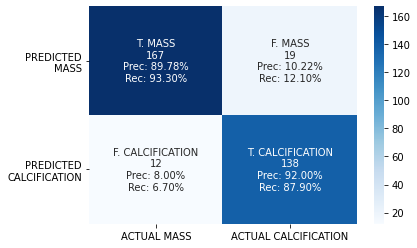

Accuracy on test set: 91.67% 
Loss on test set: 0.2408


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


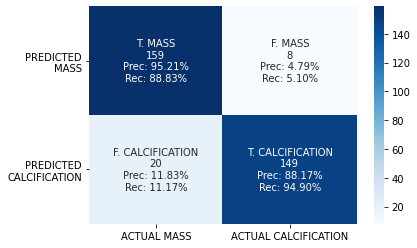

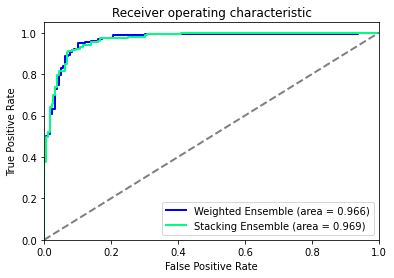

In [ ]:
# Weighted Ensemble
test_acc = accuracy_score(mc_test_labels, ensemble_weighted_prediction(members[idx], models_acc[idx],test_input_for_weghted).round())
print(f"Accuracy on test set: {round(test_acc*100, 2)}%")

ensemble_weighted_predictions = ensemble_weighted_prediction(members[idx], models_acc[idx],test_input_for_weghted)
binary_ensemble_weighted_test_predictions = ensemble_weighted_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_ensemble_weighted_test_predictions, ["MASS", "CALCIFICATION"])

# Stacking Ensemble
test_loss, test_acc = ensemle_mc.evaluate(test_input, mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

ensemle_mc_test_predictions = ensemle_mc.predict(test_input)
binary_ensemle_mc_test_predictions = ensemle_mc_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_ensemle_mc_test_predictions, ["MASS", "CALCIFICATION"])

# ROC
models_predictions = [ensemle_mc_test_predictions,
                      ensemble_weighted_predictions]

visual.plot_roc_curve(mc_test_labels, models_predictions, ["Weighted Ensemble", "Stacking Ensemble"])


Author: **Stefano Petrocchi**
